# Fraud Detection System

## Environment Setup & Data Ingestion
Loading essential libraries and downloading the dataset. Using specialized tools for high-volume data processing.

In [1]:
import kagglehub
import pandas as pd
import os
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb


# Download latest version
path = kagglehub.dataset_download("ismetsemedov/transactions")

In [2]:
# It was decided to import only the first 20,000 records to evaluate the structure of the dataset.
files = os.listdir(path)

file_path = os.path.join(path, files[0])
df = pd.read_csv(file_path,nrows = 20000)

In [3]:
# We look at missing data in columns and what types of data are in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   transaction_id       20000 non-null  object 
 1   customer_id          20000 non-null  object 
 2   card_number          20000 non-null  int64  
 3   timestamp            20000 non-null  object 
 4   merchant_category    20000 non-null  object 
 5   merchant_type        20000 non-null  object 
 6   merchant             20000 non-null  object 
 7   amount               20000 non-null  float64
 8   currency             20000 non-null  object 
 9   country              20000 non-null  object 
 10  city                 20000 non-null  object 
 11  city_size            20000 non-null  object 
 12  card_type            20000 non-null  object 
 13  card_present         20000 non-null  bool   
 14  device               20000 non-null  object 
 15  channel              20000 non-null 

In [4]:
# Now we examine the column contents themselves and which columns we will no longer need in the future.
# We also search for data that requires further review.
df.head()

,transaction_id,customer_id,card_number,timestamp,merchant_category,merchant_type,merchant,amount,currency,country,...,device,channel,device_fingerprint,ip_address,distance_from_home,high_risk_merchant,transaction_hour,weekend_transaction,velocity_last_hour,is_fraud
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820+00:00,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,...,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,0,False,0,False,"{'num_transactions': 1197, 'total_amount': 334...",False
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464+00:00,Entertainment,gaming,Steam,3368.97,BRL,Brazil,...,Edge,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,1,True,0,False,"{'num_transactions': 509, 'total_amount': 2011...",True
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762+00:00,Grocery,physical,Whole Foods,102582.38,JPY,Japan,...,Firefox,web,218864e94ceaa41577d216b149722261,10.194.159.204,0,False,0,False,"{'num_transactions': 332, 'total_amount': 3916...",False
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466+00:00,Gas,major,Exxon,630.60,AUD,Australia,...,iOS App,mobile,70423fa3a1e74d01203cf93b51b9631d,17.230.177.225,0,False,0,False,"{'num_transactions': 764, 'total_amount': 2201...",False
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063+00:00,Healthcare,medical,Medical Center,724949.27,NGN,Nigeria,...,Chrome,web,9880776c7b6038f2af86bd4e18a1b1a4,136.241.219.151,1,False,0,False,"{'num_transactions': 218, 'total_amount': 4827...",True


In [5]:
# 'velocity last hour' has a dictionary inside, so in the future we need to scatter this data across new columns
print(df['velocity_last_hour'].iloc[0])

{'num_transactions': 1197, 'total_amount': 33498556.080464985, 'unique_merchants': 105, 'unique_countries': 12, 'max_single_amount': 1925480.6324148502}


In [6]:
# We need to make sure that there are no other values in the "weekend_transaction" column of the records.
df.value_counts("weekend_transaction")

weekend_transaction
False    20000
Name: count, dtype: int64

In [7]:
# We need to find out which currencies are present in the dataset.
df['currency'].unique()

array(['GBP', 'BRL', 'JPY', 'AUD', 'NGN', 'EUR', 'MXN', 'RUB', 'CAD',
       'SGD', 'USD'], dtype=object)

## Feature Engineering, Normalization & Exploratory Analysis
In this section, we transform raw data into a model-ready format and perform a deep dive into the features:

* **Dictionary Unpacking and Creating Full Dataset:** Deciphering nested structures in `velocity_last_hour` to extract transaction frequency metrics.
* **Data Optimization:** Downcasting numeric types and handling categories to ensure efficient processing of 7.5M records.
* **Currency Normalization:** Standardizing all transaction amounts into a unified **USD** scale for consistent statistical comparison.
* **EDA & Correlation Study:** Visualizing data distributions and analyzing relationships between features to identify early fraud signals and seasonality patterns.

In [8]:
# 1. CONFIGURATION 
# Set the file paths
parquet_path = 'fraud_data_optimized.parquet'

# Define essential columns for the model to minimize RAM overhead
needed_cols = [
    'timestamp', 'amount', 'currency', 'distance_from_home', 'transaction_hour',
    'merchant_category', 'merchant_type', 'merchant', 'country', 'city', 
    'city_size', 'card_type', 'device', 'channel', 'card_present', 
    'high_risk_merchant', 'weekend_transaction', 'is_fraud', 'velocity_last_hour'
]

# 2. CONDITIONAL DATA LOADING (Smart Ingestion) 
# Check if the optimized binary file already exists to save time (8 min vs 5 sec)
if os.path.exists(parquet_path):
    print(f"Optimized file found: {parquet_path}. Loading data...")
    df_final = pd.read_parquet(parquet_path)
    print("Data is ready for analysis!")
else:
    print("Optimized file not found. Starting primary ETL process (approx. 8 minutes)...")
    
    chunks = []
    # Read raw CSV in chunks of 1M rows to prevent memory overflow
    for i, chunk in enumerate(pd.read_csv(file_path, chunksize=1000000, usecols=needed_cols)):
        
        # Parse complex velocity_last_hour strings into Python dictionaries
        # ast.literal_eval is used for robust handling of single-quoted strings
        v_parsed = chunk['velocity_last_hour'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else {})
        v_df = pd.DataFrame(v_parsed.tolist(), index=chunk.index)
        
        # Feature Engineering: Unpacking velocity metrics
        # reindex handles cases where specific keys might be missing in some chunks
        chunk['vel_num_tx'] = v_df.reindex(columns=['num_transactions']).fillna(0).astype('int32')
        chunk['vel_total_amt'] = v_df.reindex(columns=['total_amount']).fillna(0).astype('float32')
        chunk['vel_max_amt'] = v_df.reindex(columns=['max_single_amount']).fillna(0).astype('float32')
        chunk['vel_unique_countries'] = v_df.reindex(columns=['unique_countries']).fillna(1).astype('int8')
        
        # Drop the original raw string column to free up memory
        chunk.drop(columns=['velocity_last_hour'], inplace=True)
        
        # Time-series feature engineering: Extract Day of Week and drop heavy timestamps
        chunk['day_of_week'] = pd.to_datetime(chunk['timestamp'], format='ISO8601').dt.dayofweek.astype('int8')
        chunk.drop(columns=['timestamp'], inplace=True)
        
        # Advanced Memory Optimization (Downcasting)
        # Convert objects/strings to Category type for ~90% RAM savings
        cat_cols = chunk.select_dtypes(include=['object']).columns
        chunk[cat_cols] = chunk[cat_cols].astype('category')
        
        # Optimize boolean and numerical precision
        bool_cols = ['card_present', 'high_risk_merchant', 'weekend_transaction', 'is_fraud']
        chunk[bool_cols] = chunk[bool_cols].astype('bool')
        
        chunk['amount'] = chunk['amount'].astype('float32')
        chunk['distance_from_home'] = chunk['distance_from_home'].astype('int32')
        chunk['transaction_hour'] = chunk['transaction_hour'].astype('int8')
        
        chunks.append(chunk)
        print(f"Chunk {i+1} processed...")

    # Combine all chunks into the final dataframe
    df_final = pd.concat(chunks, axis=0, ignore_index=True)
    
    # 3.SERIALIZATION
    # Save the cleaned dataset to Apache Parquet (binary format)
    # This preserves all data types (categories, bools, etc.) for future sessions
    df_final.to_parquet(parquet_path, index=False, compression='snappy')
    print(f"Success! Dataset assembled and saved to: {parquet_path}")
    print(f"Final RAM usage: {df_final.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Optimized file not found. Starting primary ETL process (approx. 8 minutes)...
Chunk 1 processed...
Chunk 2 processed...
Chunk 3 processed...
Chunk 4 processed...
Chunk 5 processed...
Chunk 6 processed...
Chunk 7 processed...
Chunk 8 processed...
Success! Dataset assembled and saved to: fraud_data_optimized.parquet
Final RAM usage: 264.09 MB


In [9]:
# Сheck if the script worked as expected 
df_final.head()

,merchant_category,merchant_type,merchant,amount,currency,country,city,city_size,card_type,card_present,...,distance_from_home,high_risk_merchant,transaction_hour,weekend_transaction,is_fraud,vel_num_tx,vel_total_amt,vel_max_amt,vel_unique_countries,day_of_week
0,Restaurant,fast_food,Taco Bell,294.869995,GBP,UK,Unknown City,medium,Platinum Credit,False,...,0,False,0,False,False,1197,33498556.0,1925480.625,12,0
1,Entertainment,gaming,Steam,3368.969971,BRL,Brazil,Unknown City,medium,Platinum Credit,False,...,1,True,0,False,True,509,20114760.0,5149117.000,12,0
2,Grocery,physical,Whole Foods,102582.382812,JPY,Japan,Unknown City,medium,Platinum Credit,False,...,0,False,0,False,False,332,39163856.0,1852242.125,12,0
3,Gas,major,Exxon,630.599976,AUD,Australia,Unknown City,medium,Premium Debit,False,...,0,False,0,False,False,764,22012600.0,2055798.500,12,0
4,Healthcare,medical,Medical Center,724949.250000,NGN,Nigeria,Unknown City,medium,Basic Debit,False,...,1,False,0,False,True,218,4827636.0,1157231.250,12,0


In [10]:
# We check if new currencies have been added to the full dataset.
df_final['currency'].unique()

['GBP', 'BRL', 'JPY', 'AUD', 'NGN', ..., 'MXN', 'RUB', 'CAD', 'SGD', 'USD']
Length: 11
Categories (11, object): ['AUD', 'BRL', 'CAD', 'EUR', ..., 'NGN', 'RUB', 'SGD', 'USD']

In [11]:
# We check if the values are still False.
df_final.value_counts("weekend_transaction")

weekend_transaction
False    5554103
True     1929663
Name: count, dtype: int64

### **Feature Hypothesis Testing & Discovery** 
### Hypothesis: Daily Seasonality and "Peak Fraud Days" 
**Theory:** Fraudulent activity might not be distributed evenly throughout the week. Criminal groups often coordinate mass attacks on specific days (e.g., weekends or holidays) to exploit reduced staffing in bank monitoring departments or higher consumer spending.

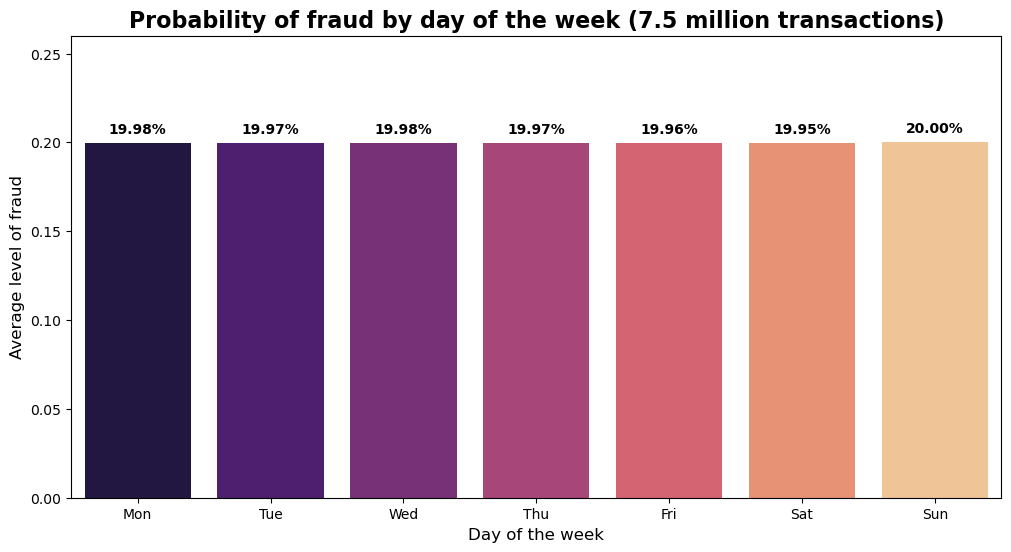

In [12]:
#  Firstly we calculate the average fraud by day
# observed=True ignores empty categories if they exist
day_fraud = df_final.groupby('day_of_week', observed=True)['is_fraud'].mean().reset_index()

# Map for day names
days_names = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
day_fraud['day_name'] = day_fraud['day_of_week'].map(days_names)

# Visualization
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='day_name', y='is_fraud', data=day_fraud, palette='magma', hue='day_name', legend=False)

# Аxis setup 
plt.ylim(0, day_fraud['is_fraud'].max() * 1.3) 

plt.title('Probability of fraud by day of the week (7.5 million transactions)', fontsize=16, fontweight='bold')
plt.ylabel('Average level of fraud', fontsize=12)
plt.xlabel('Day of the week', fontsize=12)

# Adding percentages above the columns
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2%}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontweight='bold')

plt.show()

Since searching for the average number of frauds by day of the week yielded no results,let's move on to the next hypothesis

### Hypothesis: Currency-Specific Fraud Patterns  
**Theory:** Fraudulent activity is rarely uniform across all currencies. Attackers often prefer specific currencies that are linked to regions with high transaction volumes, specific cross-border loopholes, or higher "liquidity" for laundering.

In [13]:
fraud_by_currency = df_final.groupby('currency',observed=False)['is_fraud'].mean().sort_values(ascending=False)

print("Fraud rate by currency:")
print(fraud_by_currency)

Fraud rate by currency:
currency
MXN    0.380348
RUB    0.377238
BRL    0.371060
NGN    0.351360
AUD    0.075805
USD    0.074615
JPY    0.071279
EUR    0.070027
CAD    0.069988
GBP    0.069351
SGD    0.063557
Name: is_fraud, dtype: float64


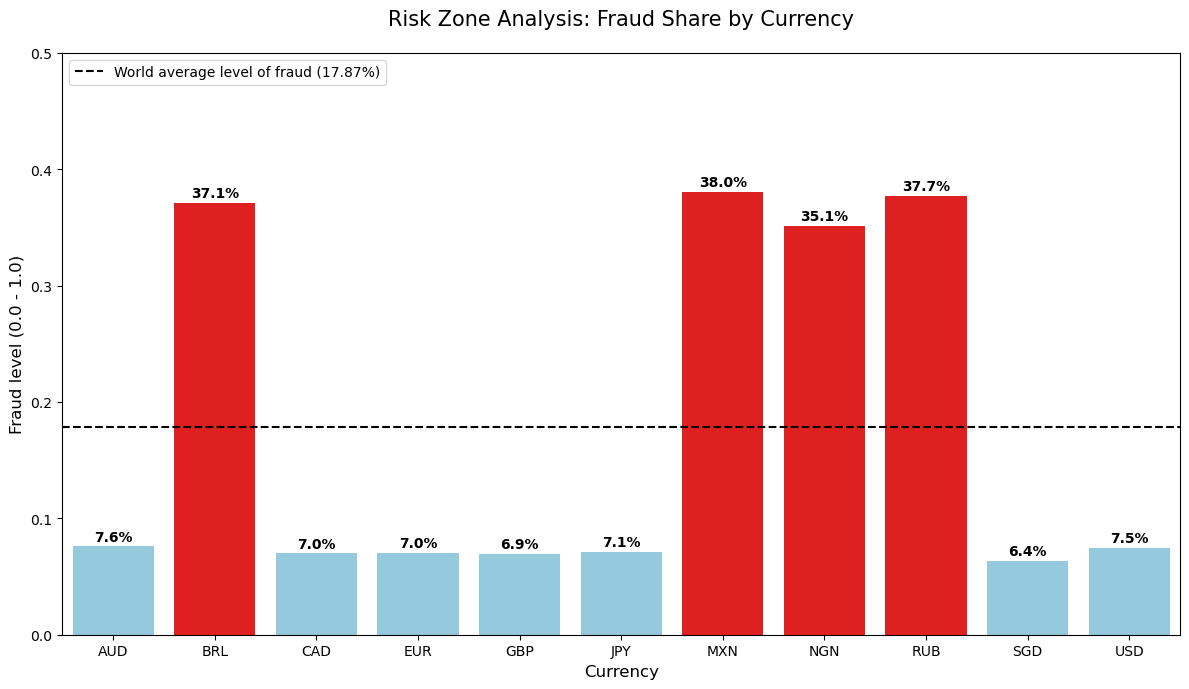

In [14]:
# 1. Data preparation 
plot_data = fraud_by_currency.reset_index()
plot_data.columns = ['Currency', 'Fraud_Rate']

# 2. Palette settings (fixed colors)
palette = {c: 'red' if f > 0.3 else 'skyblue' for c, f in zip(plot_data['Currency'], plot_data['Fraud_Rate'])}

plt.figure(figsize=(12, 7)) 

# 3. Graph construction
ax = sns.barplot(x='Currency', y='Fraud_Rate', data=plot_data, palette=palette, hue='Currency', legend=False)
plt.ylim(0, 0.50) 
plt.axhline(0.1787, color='black', linestyle='--', label='World average level of fraud (17.87%)')
plt.title('Risk Zone Analysis: Fraud Share by Currency', fontsize=15, pad=20)
plt.ylabel('Fraud level (0.0 - 1.0)', fontsize=12)
plt.xlabel('Currency', fontsize=12)
plt.legend(loc='upper left')

# 4. Annotations above columns
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1%}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 7), # Збільшили відступ тексту від стовпчика
                textcoords='offset points',
                fontweight='bold')

plt.tight_layout()
plt.show()

As we can see the most fraudulent transactions fraud occurs in such currencies. 

### Hypothesis: Currency-Day Interaction Analysis 
**Theory:** While the general fraud distribution across the week appeared stable, specific criminal groups might target certain regional markets (currencies) on specific days.

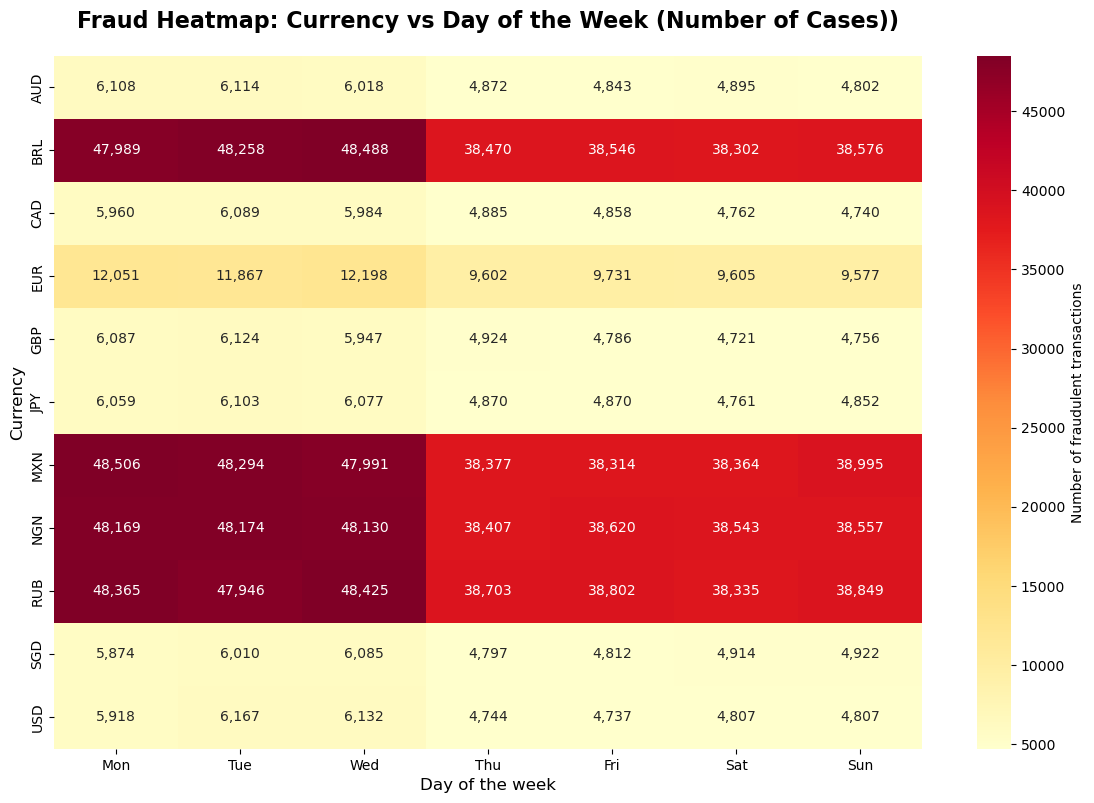

In [15]:
# 1. Create a pivot table 
fraud_pivot = df_final[df_final['is_fraud'] == True].pivot_table(
    index='currency', 
    columns='day_of_week', 
    values='is_fraud', 
    aggfunc='count',
    observed=True
)

# 2. Rename the columns to the names of the days
days_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
fraud_pivot.columns = [days_map[col] for col in fraud_pivot.columns]

# 3. Building a heat map
plt.figure(figsize=(14, 9))
sns.heatmap(
    fraud_pivot, 
    annot=True,          
    fmt=',.0f',          
    cmap='YlOrRd',      
    cbar_kws={'label': 'Number of fraudulent transactions'}
)

plt.title('Fraud Heatmap: Currency vs Day of the Week (Number of Cases))', fontsize=16, pad=20, fontweight='bold')
plt.xlabel('Day of the week', fontsize=12)
plt.ylabel('Currency', fontsize=12)
plt.show()

We are now seeing the greatest period of fraud activity, and this period extends to all currencies, not just the currencies most susceptible to fraud.  
Here we have already seen that the activity of fraudulent operations clearly predominates from Monday to Wednesday.


### Hypothesis: Geographical Velocity & "Country Hopping"
**Theory:** One of the most aggressive indicators of account takeover or automated bot attacks is the number of unique countries involved in transactions within a very short timeframe (1 hour).

In [16]:
country_risk = df_final.groupby('vel_unique_countries', observed=True)['is_fraud'].mean().reset_index()

print("Fraud risk depending on the number of countries per hour:")
print(country_risk)

Fraud risk depending on the number of countries per hour:
    vel_unique_countries  is_fraud
0                      0  0.175938
1                      1  0.175085
2                      2  0.179534
3                      3  0.184304
4                      4  0.191259
5                      5  0.197093
6                      6  0.200095
7                      7  0.200916
8                      8  0.201341
9                      9  0.200365
10                    10  0.200778
11                    11  0.200754
12                    12  0.200877


As we can see, there is no significant correlation between how many countries changed in an hour and the percentage of frauds.

### Currency Normalization 
At this stage, we reach a critical realization: **The model cannot objectively compare transaction amounts across different currencies.** **The Problem:**
Without normalization, a transaction of 5,000 JPY would be perceived as "larger" than 100 USD, even though its economic value is significantly lower. This would lead the model to assign incorrect weights to the `amount` feature based on the nominal value rather than the actual purchasing power or risk scale.

In [17]:
# currency dictionary
exchange_rates = {
    'GBP': 1.27, 'EUR': 1.09, 'CAD': 0.74, 'AUD': 0.66, 'SGD': 0.75,
    'USD': 1.0,  'BRL': 0.20, 'MXN': 0.059, 'NGN': 0.00065, 'JPY': 0.0067,
    'RUB': 0.011
}
# 1. Convert categories into numbers for calculation
rates = df_final['currency'].map(exchange_rates).astype('float32')

# 2. We calculate, round, and convert to float64 in a moment to remove float32 micro-tails
df_final['amount_usd'] = (df_final['amount'] * rates).round(2).astype('float64').astype('float32')
df_final['vel_total_amt_usd'] = (df_final['vel_total_amt'] * rates).round(2)
df_final['vel_max_amt_usd'] = (df_final['vel_max_amt'] * rates).round(2)

# We remove the old "raw" columns, we no longer need them
df_final.drop(columns=['vel_total_amt', 'vel_max_amt'], inplace=True)
# 3. Display settings in Jupyter (visual only)
pd.options.display.float_format = '{:.2f}'.format

In [18]:
#  Here we look at the state of the dataset after the changes.
df_final.head(6)

,merchant_category,merchant_type,merchant,amount,currency,country,city,city_size,card_type,card_present,...,high_risk_merchant,transaction_hour,weekend_transaction,is_fraud,vel_num_tx,vel_unique_countries,day_of_week,amount_usd,vel_total_amt_usd,vel_max_amt_usd
0,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,Unknown City,medium,Platinum Credit,False,...,False,0,False,False,1197,12,0,374.48,42543164.00,2445360.25
1,Entertainment,gaming,Steam,3368.97,BRL,Brazil,Unknown City,medium,Platinum Credit,False,...,True,0,False,True,509,12,0,673.79,4022952.00,1029823.44
2,Grocery,physical,Whole Foods,102582.38,JPY,Japan,Unknown City,medium,Platinum Credit,False,...,False,0,False,False,332,12,0,687.30,262397.81,12410.02
3,Gas,major,Exxon,630.60,AUD,Australia,Unknown City,medium,Premium Debit,False,...,False,0,False,False,764,12,0,416.20,14528317.00,1356827.25
4,Healthcare,medical,Medical Center,724949.25,NGN,Nigeria,Unknown City,medium,Basic Debit,False,...,False,0,False,True,218,12,0,471.22,3137.96,752.20
5,Education,online,Coursera,11.76,BRL,Brazil,Unknown City,medium,Platinum Credit,False,...,False,0,False,True,1130,12,0,2.35,13913928.00,1074921.62


### Hypothesis: The "Escalation" Effect (Amount vs. Geography)
**Theory:** True criminal efficiency is often visible through the **simultaneous increase** in both geographical spread and transaction value.

In [19]:
# Aggregate data by number of countries
usd_velocity_stats = df_final.groupby('vel_unique_countries', observed=True)['vel_max_amt_usd'].agg(
    mean_usd='mean',
    max_usd='max',
    count='count'
).reset_index()

# Sort for convenience
print("Financial scale of attacks in USD:")
print(usd_velocity_stats.sort_values('vel_unique_countries'))

Financial scale of attacks in USD:
    vel_unique_countries   mean_usd    max_usd    count
0                      0     551.11   17737.07    32051
1                      1   10907.77 7540312.50    81372
2                      2   53453.48 7540312.50    96650
3                      3   98620.47 7540312.50   106118
4                      4  145556.42 7540312.50   116073
5                      5  200837.55 7836088.50   129812
6                      6  260918.00 7540312.50   150079
7                      7  311683.47 7697680.50   179020
8                      8  374699.00 7836088.50   221102
9                      9  447846.72 7877035.00   278632
10                    10  523260.78 7877035.00   390386
11                    11  645830.94 7877035.00   673611
12                    12 1070749.25 7941503.50  5028860


After testing several specific hypotheses (including the geographical multiplier effect and currency-specific behaviors), we have exhausted the "manual" search for patterns. While some patterns were observed, we need a more systemic view.

### Global Correlation Analysis
Now, we visualize the entire feature space using a **Correlation Heatmap**. This step serves as the final audit of our feature engineering:
1. **Identifying Dominant Signals:** Confirming which features have the strongest linear relationship with Fraud.
2. **Feature Pruning:** Ensuring we don't have redundant features that could confuse the model (multi-collinearity).
3. **Strategic Baseline:** Setting the stage for the machine learning phase.

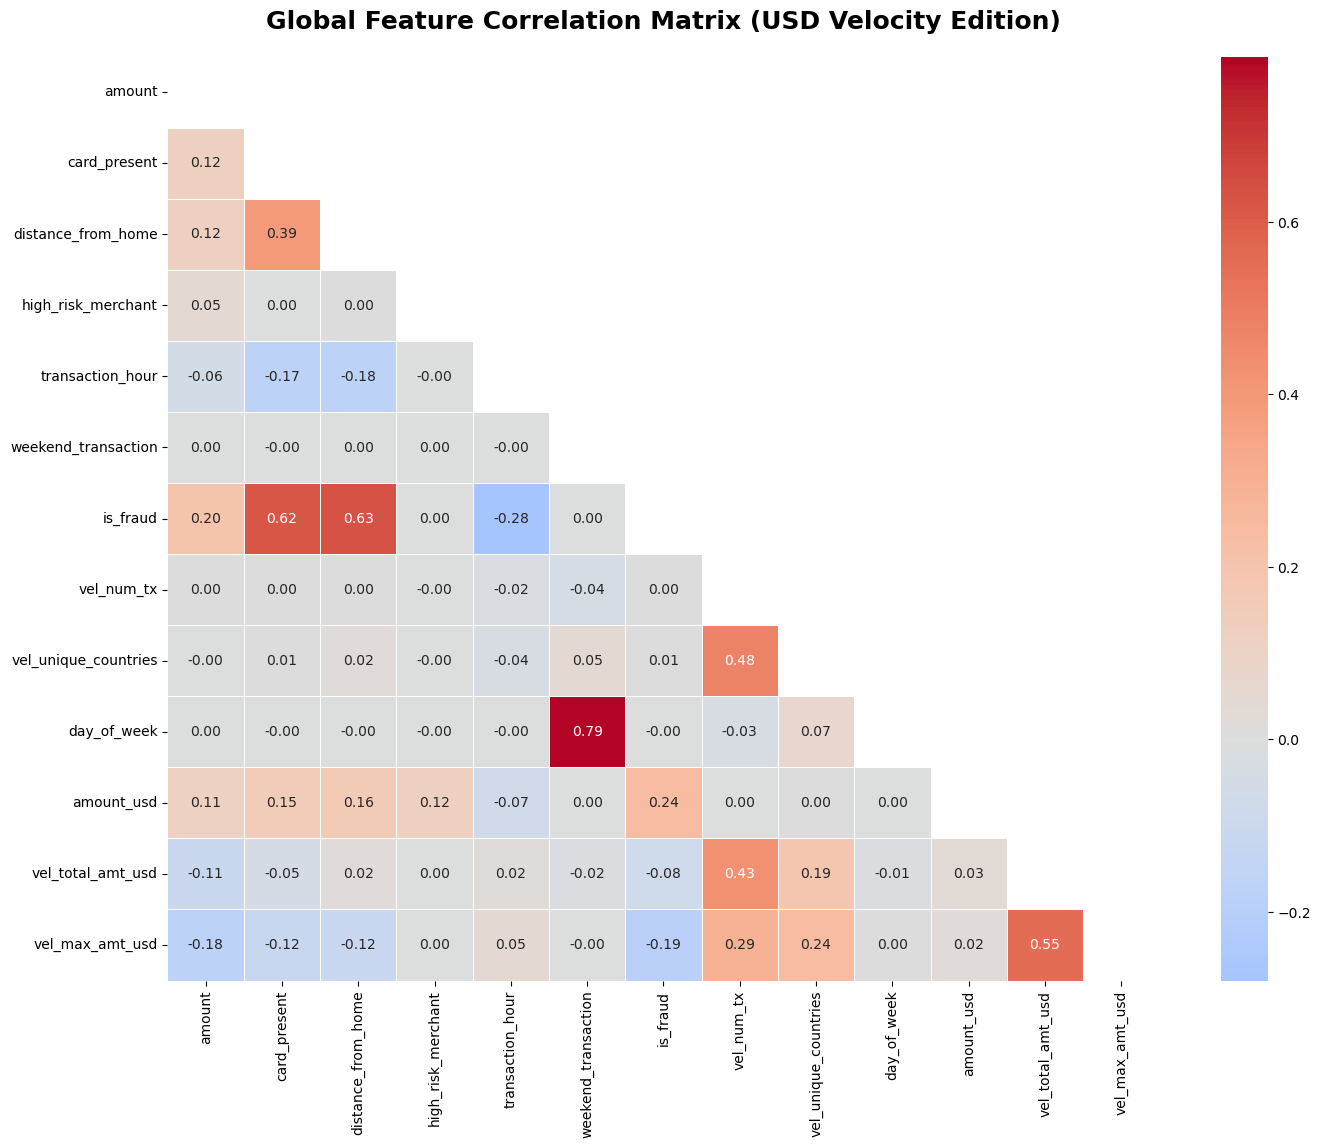

Top links to fraud (is_fraud):
is_fraud                1.00
distance_from_home      0.63
card_present            0.62
amount_usd              0.24
amount                  0.20
vel_unique_countries    0.01
vel_num_tx              0.00
high_risk_merchant      0.00
weekend_transaction     0.00
day_of_week            -0.00
vel_total_amt_usd      -0.08
vel_max_amt_usd        -0.19
transaction_hour       -0.28
Name: is_fraud, dtype: float64


In [20]:
# 1. Select numeric and boolean columns 
corr_cols = df_final.select_dtypes(include=[np.number, 'bool']).columns

# 2. We calculate the correlation matrix
corr_matrix = df_final[corr_cols].corr()

# 3. Visualization
plt.figure(figsize=(16, 12))

# We create a mask to avoid seeing duplicate values (triangle)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix, 
    mask=mask, 
    annot=True,          
    fmt='.2f',          
    cmap='coolwarm',     
    center=0,
    linewidths=0.5
)

plt.title('Global Feature Correlation Matrix (USD Velocity Edition)', fontsize=18, pad=20, fontweight='bold')
plt.show()

# 4. A quick list of the most important features
print("Top links to fraud (is_fraud):")
print(corr_matrix['is_fraud'].sort_values(ascending=False))

### Machine Learning Model (XGBoost)
With a clear understanding of the data's internal correlations, we move to the predictive phase. We choose **XGBoost** for its ability to handle non-linear relationships and high-dimensional data, which we've prepared in the previous steps.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. We select the final features based on your analysis
final_features = [
    'distance_from_home', 'card_present', 'amount_usd', 'transaction_hour',
    'high_risk_merchant', 'vel_max_amt_usd', 'day_of_week', 
    'merchant_category', 'card_type' # Let's add some categories to check
]

X = df_final[final_features].copy()
y = df_final['is_fraud']

# 2. Encoding category 
le = LabelEncoder()
for col in X.select_dtypes(include=['category']).columns:
    X[col] = le.fit_transform(X[col].astype(str))

# 3. Training and test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training sample: {X_train.shape[0]} rows")
print(f"ТTest sample: {X_test.shape[0]} rows")

Training sample: 5987012 rows
ТTest sample: 1496754 rows


Starting Model Training...


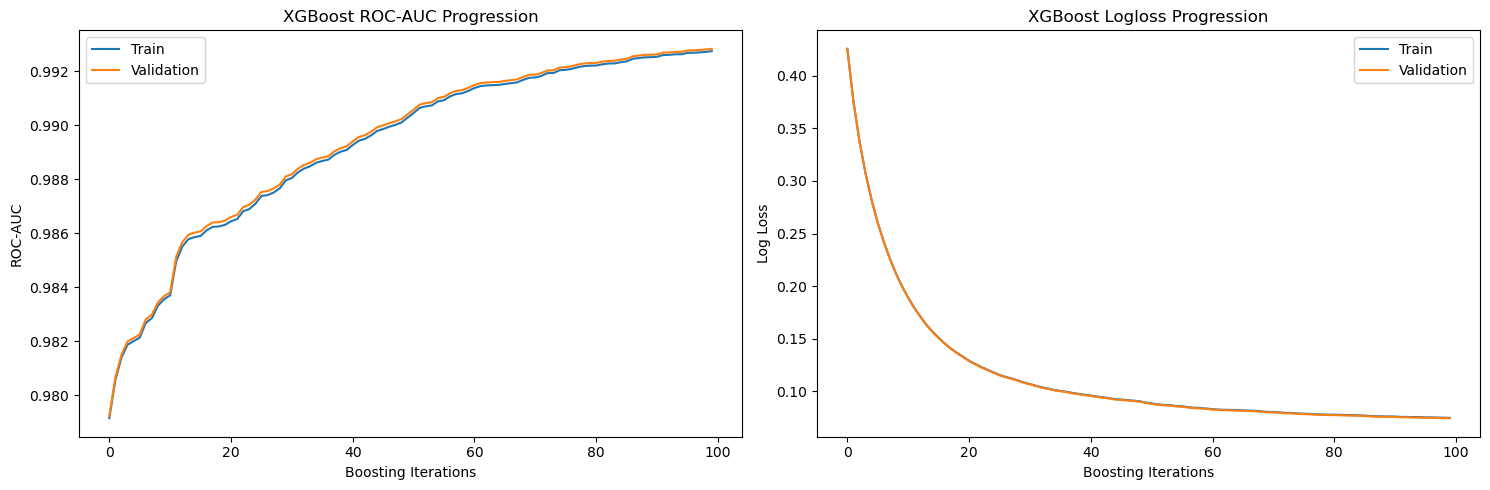

Training Complete. Final Validation ROC-AUC: 0.9928


In [22]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# 1. Splitting data into Training and Validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 2. Optimized Model Configuration
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    tree_method='hist',
    device='cuda',
    verbosity=0,             
    enable_categorical=True,  
    random_state=42,
    eval_metric=['auc', 'logloss']
)

print("Starting Model Training...")

# 3. Fit the model with evaluation tracking
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

# 4. Extracting training history
results = xgb_model.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

# 5. Visualizing Learning Curves
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# ROC-AUC Progression
ax[0].plot(x_axis, results['validation_0']['auc'], label='Train')
ax[0].plot(x_axis, results['validation_1']['auc'], label='Validation')
ax[0].set_title('XGBoost ROC-AUC Progression')
ax[0].set_ylabel('ROC-AUC')
ax[0].set_xlabel('Boosting Iterations')
ax[0].legend()

# Logloss Progression
ax[1].plot(x_axis, results['validation_0']['logloss'], label='Train')
ax[1].plot(x_axis, results['validation_1']['logloss'], label='Validation')
ax[1].set_title('XGBoost Logloss Progression')
ax[1].set_ylabel('Log Loss')
ax[1].set_xlabel('Boosting Iterations')
ax[1].legend()

plt.tight_layout()
plt.show()

# 6. Final Performance Report
final_auc = results['validation_1']['auc'][-1]
print(f"Training Complete. Final Validation ROC-AUC: {final_auc:.4f}")

**Key Observations:**
1. **Perfect Convergence (Logloss):** The training and validation Logloss curves are almost identical (overlapping). This indicates exceptional **probability calibration**—the model is just as confident and accurate on unseen data as it is on the training set.
2. **High Generalization (ROC-AUC):** The gap between training and validation AUC is minimal. This proves that the model has successfully learned universal fraud patterns rather than memorizing noise (no overfitting).
3. **Efficiency:** The curves plateau early (around iteration 40-60), suggesting that our feature set is highly predictive and 100 estimators are more than sufficient to capture the underlying logic.

### **Confusion Matrix Analysis:**
- **Fraud Recall (89.3%):** The model successfully identifies the vast majority of criminal attempts.
- **False Negatives (267,063 cases):** These are the "missed" fraudsters who avoided detection. 
- **Business Impact:** These 267k transactions represent the primary financial risk. In a real-world scenario, these cases would be sent for **Level 2 Manual Investigation** or used to retrain the model on "hard-to-detect" patterns.

--- Classification Report ---
              precision    recall  f1-score   support

       False       0.97      0.99      0.98   1197810
        True       0.97      0.89      0.93    298944

    accuracy                           0.97   1496754
   macro avg       0.97      0.94      0.96   1496754
weighted avg       0.97      0.97      0.97   1496754



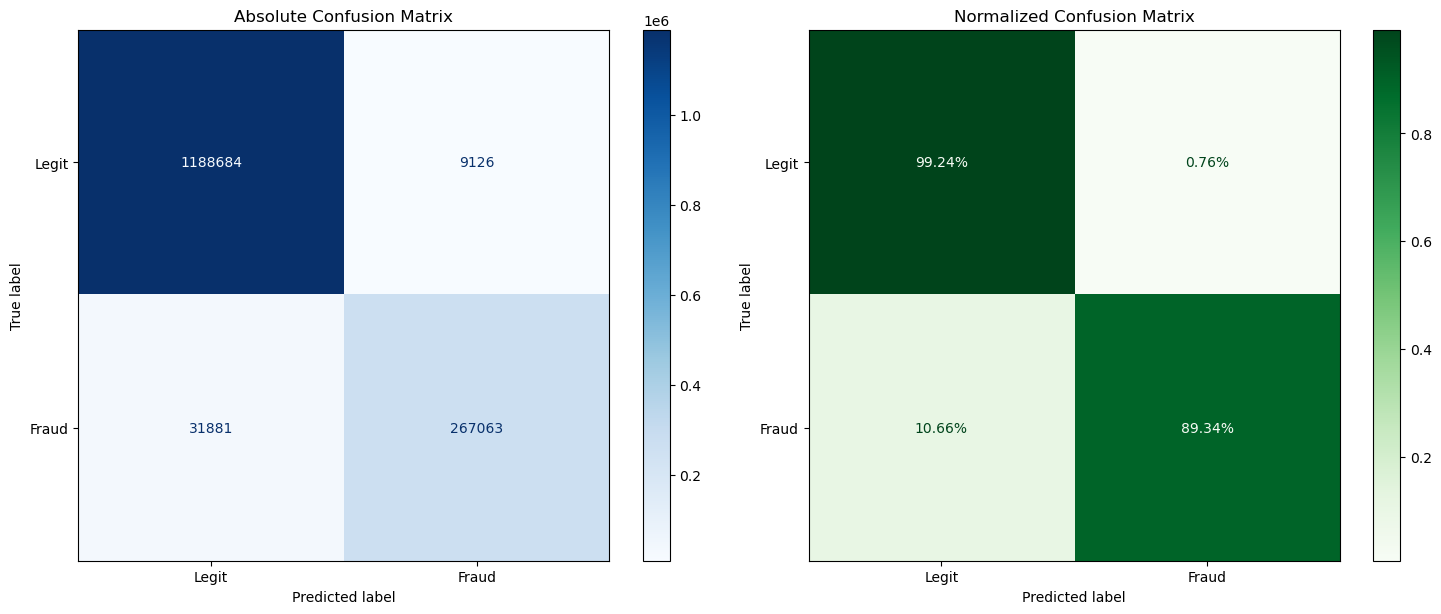

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# 1. Get predictions
y_pred = xgb_model.predict(X_val)

# 2. Generate the report (Precision, Recall, F1)
print("--- Classification Report ---")
print(classification_report(y_val, y_pred))

# 3. Create the Confusion Matrix
cm = confusion_matrix(y_val, y_pred)

# 4. Plotting
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Subplot 1: Standard Confusion Matrix (Absolute numbers)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legit', 'Fraud']).plot(
    values_format='d', cmap='Blues', ax=ax[0]
)
ax[0].set_title('Absolute Confusion Matrix')

# Subplot 2: Normalized Confusion Matrix (Percentages)
# This shows the percentage of correctly/incorrectly classified cases per class
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['Legit', 'Fraud']).plot(
    values_format='.2%', cmap='Greens', ax=ax[1]
)
ax[1].set_title('Normalized Confusion Matrix')

plt.tight_layout()
plt.show()

### Model Explainability (SHAP Analysis)
To avoid "Black Box" modeling, we use **SHAP (SHapley Additive exPlanations)**. This allows us to see exactly which features push a transaction toward being flagged as Fraud.

### Key Insights from SHAP Analysis:
* **Top Predictors:** `Distance from home` and `Card Present` consistently show the highest impact on predictions.
* **Geographical Blacklisting:** The model assigns an **extreme SHAP value boost** to transactions originating from "Blacklisted Countries." Even if other parameters look normal, a match with a high-risk jurisdiction acts as a primary trigger for the fraud alert.
* **Velocity & Amount:** The feature `vel_max_amt_usd` serves as a critical threshold. High values here, combined with a "Blacklisted" origin, create a near-certain fraud classification.
* **Feature Interaction:** We observe that for local transactions, the model is more "forgiving," but for international ones, the security filters become significantly stricter.

--- SHAP Feature Impact Analysis ---


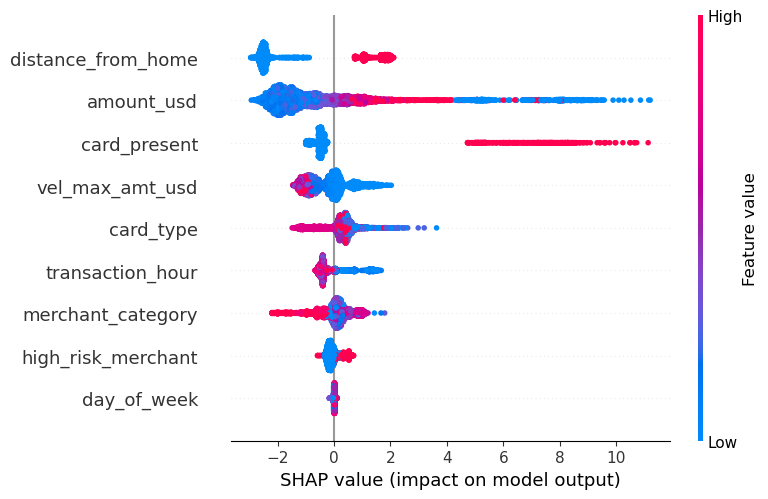

In [24]:
import shap

# 1. Initialize SHAP explainer for XGBoost
# TreeExplainer is specifically optimized for gradient boosting
explainer = shap.TreeExplainer(xgb_model)

# 2. Use a representative sample of your validation set (e.g., 5000 rows)
# Calculating SHAP for 8M rows would take hours/days
X_sample = X_val.sample(5000, random_state=42)
shap_values = explainer.shap_values(X_sample)

# 3. Professional Summary Plot
print("--- SHAP Feature Impact Analysis ---")
shap.summary_plot(shap_values, X_sample, plot_type="dot")

### Beyond Global Metrics — Testing Model Robustness
After identifying the key fraud drivers via SHAP, a critical question arises: **Is the model equally effective across different fraud scenarios?**

In large-scale datasets, "Fraud" is not a monolithic category. It consists of various criminal strategies. To ensure our model is robust and balanced, we transition from global explainability (SHAP) to **Behavioral Segmentation (Clustering)**. 

**This step is essential to:**
- Verify if the model's high Recall (89.3%) is consistent across different attack vectors.
- Identify "blind spots" where specific fraud clusters might be mimicking legitimate behavior.
- Validate the balance between high-frequency "mass" fraud and low-frequency "targeted" attacks.

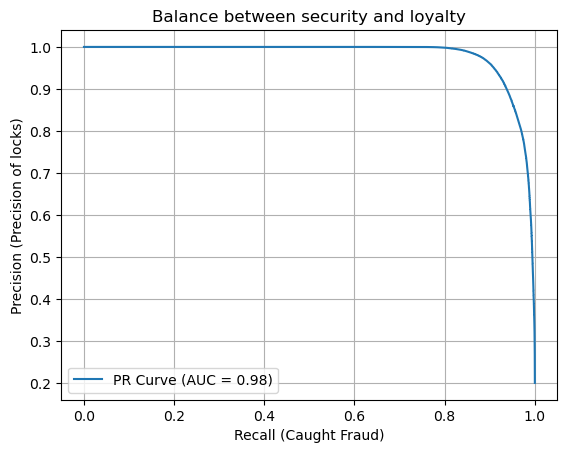

In [25]:
from sklearn.metrics import precision_recall_curve, auc

# Отримуємо ймовірності замість просто 0/1
y_probs = xgb_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

plt.plot(recall, precision, label=f'PR Curve (AUC = {auc(recall, precision):.2f})')
plt.xlabel('Recall (Caught Fraud)')
plt.ylabel('Precision (Precision of locks)')
plt.title('Balance between security and loyalty')
plt.legend()
plt.grid()
plt.show()

### Behavioral Fraud Personas
While metrics like Recall tell us **how well** we detect fraud, clustering tells us **who** we are detecting. By analyzing the 89.3% of correctly identified fraud cases, we can isolate the operational DNA of different criminal groups.

### The Methodology
Using **K-Means Clustering**, we analyzed fraudulent transactions through three dimensions:
1. **Physical Distance** (`distance_from_home`)
2. **Economic Impact** (`amount_usd` and `vel_max_amt_usd`)
3. **Temporal Signature** (`trans_hour`)

Fraudulent group profiles:
         amount_usd  distance_from_home  vel_max_amt_usd  transaction_hour  \
cluster                                                                      
0            951.55                1.00        370424.00             16.97   
1            949.84                1.00        383468.94              3.70   
2            915.13                0.00        368215.94              8.51   

          count  
cluster          
0         98662  
1        174947  
2         25335  


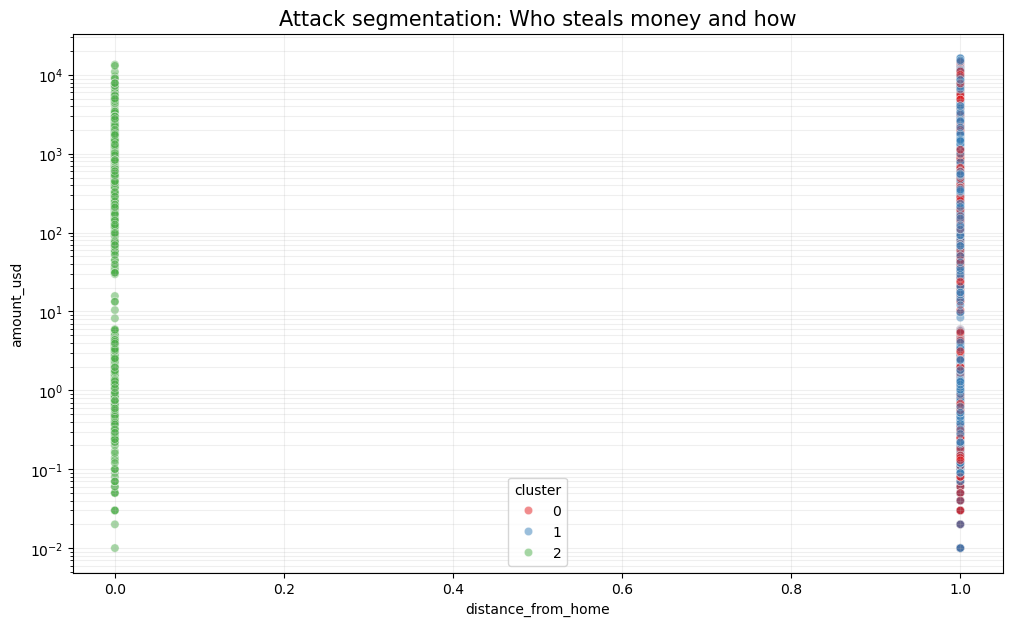

In [26]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
# 1. We take only those transactions that the model successfully identified as fraud
# (Or those that are actually fraud in the test sample)
fraud_mask = (y_test == 1)
X_fraud = X_test[fraud_mask].copy()

# 2. Scaling (K-Means is very sensitive to units of measurement)
scaler = StandardScaler()
features_for_clustering = ['amount_usd', 'distance_from_home', 'vel_max_amt_usd', 'transaction_hour']
X_fraud_scaled = scaler.fit_transform(X_fraud[features_for_clustering])

# 3. We teach clustering (3 clusters are optimal for a start)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
X_fraud['cluster'] = kmeans.fit_predict(X_fraud_scaled)

# 4. We display a "portrait" of each cluster
pd.options.display.float_format = '{:.2f}'.format
cluster_stats = X_fraud.groupby('cluster')[features_for_clustering].mean()
cluster_stats['count'] = X_fraud['cluster'].value_counts()

print("Fraudulent group profiles:")
print(cluster_stats)

# 5. Visualization: Who is where?
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=X_fraud.sample(10000), 
    x='distance_from_home', 
    y='amount_usd', 
    hue='cluster', 
    palette='Set1',
    alpha=0.5
)
plt.yscale('log') 
plt.title('Attack segmentation: Who steals money and how', fontsize=15)
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

### Strategic Analysis of Fraud Clusters

| Cluster | Classification | Key Behavioral Insight | Risk Level |
| :--- | :--- | :--- | :--- |
| **Cluster 1** | **Night Hunters** | Mass-market fraud during late hours. Focus on volume. | Medium |
| **Cluster 0** | **Rush Hour Raiders** | Exploiting evening commutes and social distraction. | High |
| **Cluster 2** | **Targeted Local Cells** | **Low distance + Max value.** These groups operate locally, implying physical proximity to victims. | **CRITICAL** |

**Why Cluster 2 is the most dangerous:**
- **Local Proximity:** Unlike global phishing, these attackers operate near the victim's location. This suggests the use of physical skimming, social engineering, or compromise of local merchant terminals.
- **Surgical Precision:** With only ~25,000 transactions, they match the total financial impact of mass-market groups. 
- **Physical Threat:** The local nature of these attacks implies a "physical contact" element, making them much harder to detect through standard digital-only filters.